------TODO------  
Check that everything is converted into RBF 

Try to estimate the radius of density around the critical diagonal that we should have in order to correct the asymmetry of grid_concentrated.

Implement Gauss quadrature, and repair RIF in order to get precise uniform bounds on integrals approximations (or maybe bound the lambda and phi separately in order to have a rough bound).

Code part :  
1- Now that smooth and nice functions are well approximated, try to approximate toy exemples of wild (continuous) functions.  
2- Improve the rate of convergence. As of right now, the finite rank kernel converges fast to a reasonable approximation, but then struggles to really converge.  
??- Repair the singular functions in order to use RIF to compute maximums. (To experiment with RIF, try to compute the max of a smooth function that reaches its maximum between 0 and 2**(-prec))

Theoretical part :  
1- Check the computations for the approximated kernel.  
2- Bound the L2/H3 norm of the kernels (real and approximation) away from zero.  

--------------

We want to approximate in $H^3(\mathbb{R})$ the kernel operator $T : f \mapsto \displaystyle \int_\mathbb{R} K(x,y)f(y)\mathrm{d}y$ using gaussians.  
Assuming that we can bound the kernel away from zero, we only need to find an approximation on a bounded (compact) domain $[-A,A]$, provided that the approximation also decays fast enough at infinity.  
We first discretize the integral operator using a Riemann sum : $ T(f)(x) \approx \displaystyle \sum_{i=1}^n \delta K(x,y_i)f(y_i) $  
Then we approximate each $K(x,y_i)$ separately using gaussians (maybe we should directly approximate the Riemann sum): $K(x,y_i) \approx \displaystyle \sum_{j=1}^n c_{i,j} e^{-\frac{(x-x_j)^2}{2\sigma}} $  
Finally, since $f\mapsto f(x_i)$ is represented in $H^3(\mathbb{R})$ by the inverse Fourier transform of $\displaystyle \frac{e^{2i\pi \xi x_i}}{(1+\xi^2)^3}$, denoted $\eta_{x_i}(x)$, the approximate operator can be written as :  
$T_n : f \mapsto \displaystyle \int_\mathbb{R} K_n(x,y)f(y)\mathrm{d}y$, where $K_n(x,y) = \displaystyle \sum_{i=1}^n \sum_{j=1}^n \delta c_{i,j} e^{ \frac{(x-x_j)^2}{2\sigma}}\eta_{y_i}(y) $.

We now need to numerically compute the $H^3([-A,A])$ norm of the difference with rigorous bounds, and hope that it is small enough for a not too large $n$.

In [2]:
## Adding the .simplify_full() command may give cleaner functions to look at, but drastically increases the runtime (from 0.5 sec to more than 4 min), and, most importantly, causes completely unstable computations that ruin the precision (for unknown reasons).
import time
import numpy as np
prec = 300
RBF = RealBallField(prec)
RIF = RealIntervalField(prec)
var('x')
assume(x, 'real')
var('y')
assume(y, 'real')

n_derivs=10  # Number of derivatives to compute


W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime
b = (3*x)/2 + W
a_derivs = [a]
a_derivs_0=[RBF(a_derivs[0].taylor(x,0,0))]
b_derivs = [b]
b_derivs_0=[RBF(b_derivs[0].taylor(x,0,0))]
for k in range(1, n_derivs):
    a_derivs.append(diff(a, x, k))
    a_derivs_0.append(RBF(a_derivs[k].taylor(x,0,0)))
    b_derivs.append(diff(b, x, k))
    b_derivs_0.append(RBF(b_derivs[k].taylor(x,0,0)))


phi_0 = -a_derivs[0] + b_derivs[1]/2 + a_derivs[2]/2 - a_derivs[4]/2 + a_derivs[6]/2
phi_1 = -a_derivs[0] - b_derivs[1]/2 + 2*a_derivs[2] + b_derivs[3]/2 - 3*a_derivs[4] - b_derivs[5]/2
phi_2 = -a_derivs[0] - (3/2)*b_derivs[1] + (9/2)*a_derivs[2] + (5/2)*b_derivs[3] 
phi_3 = -a_derivs[0] - (5/2)*b_derivs[1] # corresponds to the sign in the inequality
phi_list = [phi_0, phi_1, phi_2, phi_3]

phi_0_0 = -a_derivs_0[0] + b_derivs_0[1]/2 + a_derivs_0[2]/2 - a_derivs_0[4]/2 + a_derivs_0[6]/2
phi_1_0 = -a_derivs_0[0] - b_derivs_0[1]/2 + 2*a_derivs_0[2] + b_derivs_0[3]/2 - 3*a_derivs_0[4] - b_derivs_0[5]/2
phi_2_0 = -a_derivs_0[0] - (3/2)*b_derivs_0[1] + (9/2)*a_derivs_0[2] + (5/2)*b_derivs_0[3]
phi_3_0 = -a_derivs_0[0] - (5/2)*b_derivs_0[1]  
phi_list_0 = [phi_0_0, phi_1_0, phi_2_0, phi_3_0]


# Base Fourier function
f = (pi/4) * exp(-2*pi*abs(x)) * (2*(pi**2)*(x**2) + 3*pi*abs(x) + 3/2)
lambda_0 = f
lambda_1 = -diff(f, x)
lambda_2 = -diff(f, x, 2)
lambda_3 = 2*diff(f, x, 3)
lambda_4 = diff(f, x, 4)
lambda_list = [lambda_0,lambda_1,lambda_2,lambda_3,lambda_4]
lambda_list_0 = [limit(lambda_0,x=0),limit(lambda_1,x=0),limit(lambda_2,x=0),limit(lambda_3,x=0),limit(lambda_4,x=0)]

eta_sum = f - diff(diff(f,x),x) + diff(diff(diff(diff(f,x),x),x),x) - diff(diff(diff(diff(diff(diff(f,x),x),x),x),x),x)

M_0 = (lambda_list[0](x=x - y) * phi_list[0](x=y))
M_1 = (lambda_list[1](x=x - y) * diff(phi_list[1], x)(x=y) + lambda_list[2](x=x - y) * phi_list[1](x=y))
M_2 = (lambda_list[3](x=x - y) * diff(diff(phi_list[2], x),x)(x=y) +lambda_list[3](x=x - y) * diff(phi_list[2], x)(x=y)+ lambda_list[4](x=x - y) * phi_list[2](x=y))
M_list=[M_0,M_1,M_2]


# Converts symbolic functions to numerical ones that have RealBallField/RealIntervalField for domain
# and repair the numerical singularities at 0

def smooth_fast_callable(f,x,zero_value=RBF(0)):
    f_fast = fast_callable(f, vars=[x], domain=RBF)
    def f_modified(ball):
        return RBF(zero_value) if abs(RBF(ball).center()) <= 2**(-prec) else f_fast(RBF(ball)) # Sets the sensibility to be equal to the precision of the field
    return f_modified

a_funcs = [smooth_fast_callable(a_derivs[k],x,a_derivs_0[k]) for k in range(n_derivs)]
b_funcs = [smooth_fast_callable(b_derivs[k],x,b_derivs_0[k]) for k in range(n_derivs)]
phi_funcs = [smooth_fast_callable(phi_list[k],x,phi_list_0[k]) for k in range(4)]
lambda_funcs = [smooth_fast_callable(lambda_list[k],x,lambda_list_0[k]) for k in range(5)]

def eta_2(xi,y):
    eta_fast=smooth_fast_callable(eta_sum,x,limit(eta_sum,x=0))
    return eta_fast(y+xi)

phi_1_d1_0=diff(phi_list[1],x).taylor(x,0)
phi_1_d1_func=smooth_fast_callable(diff(phi_list[1],x),x,phi_1_d1_0)

phi_2_d1_0=diff(phi_list[2],x).taylor(x,0)
phi_2_d1_func=smooth_fast_callable(diff(phi_list[2],x),x,phi_2_d1_0)
phi_2_d2_0=diff(diff(phi_list[2],x),x).taylor(x,0)
phi_2_d2_func=smooth_fast_callable(diff(diff(phi_list[2],x),x),x,phi_2_d2_0)

def M_0_func(ball1,ball2):
   return lambda_funcs[0](ball1-ball2)*phi_funcs[0](ball2)
    
def M_1_func(ball1, ball2):
    return (lambda_funcs[1](ball1-ball2) * phi_1_d1_func(ball2) + lambda_funcs[2](ball1-ball2) * phi_funcs[1](ball2))

def M_2_func(ball1, ball2):
    return (lambda_funcs[3](ball1-ball2) * phi_2_d2_func(ball2) + lambda_funcs[3](ball1-ball2) * phi_2_d1_func(ball2) + lambda_funcs[4](ball1-ball2) * phi_funcs[2](ball2))

M_funcs=[M_0_func,M_1_func,M_2_func]

In [3]:
# Compare old and new versions

print(fast_callable(a_derivs[1],vars=[x],domain=RBF)(RBF(0)))
print(fast_callable(a_derivs[1],vars=[x],domain=RBF)(RBF(1e-30)))
print(smooth_fast_callable(a_derivs[1],x,a_derivs_0[1])(RBF(0)))

print(fast_callable(M_2,vars=[x,y],domain=RBF)(RBF(pi),RBF(0)))
print(fast_callable(M_2,vars=[x,y],domain=RBF)(RBF(pi),RBF(1e-10)))
print(M_2_func(RBF(pi),RBF(0)))

nan
[+/- 1.22e-29]
0
nan
[0.51736622759128395985483290828673397760526 +/- 9.45e-42]
[0.5173662272529380622927259051773918509977128607682167618716583810898046467049344833149964 +/- 5.76e-89]


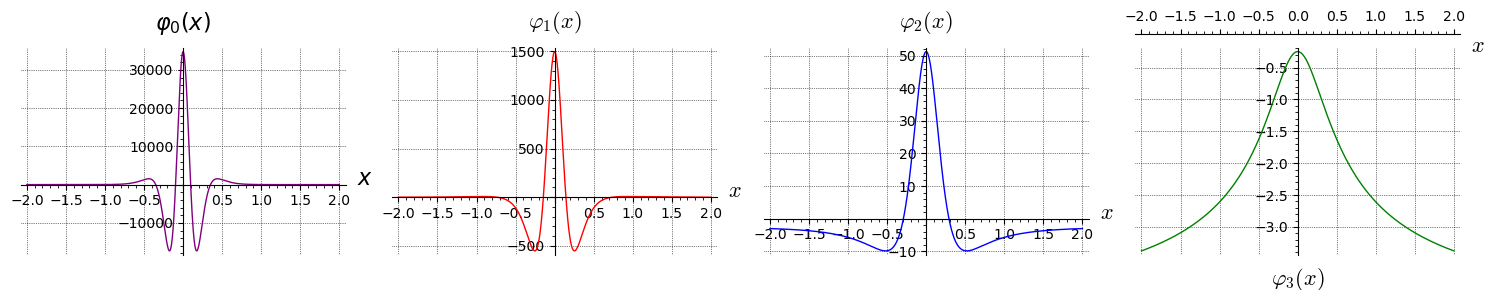

In [4]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(4):
    axes_label = [r'$x$', f'$\\varphi_{{{k}}}(x)$']
    p = plot(phi_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

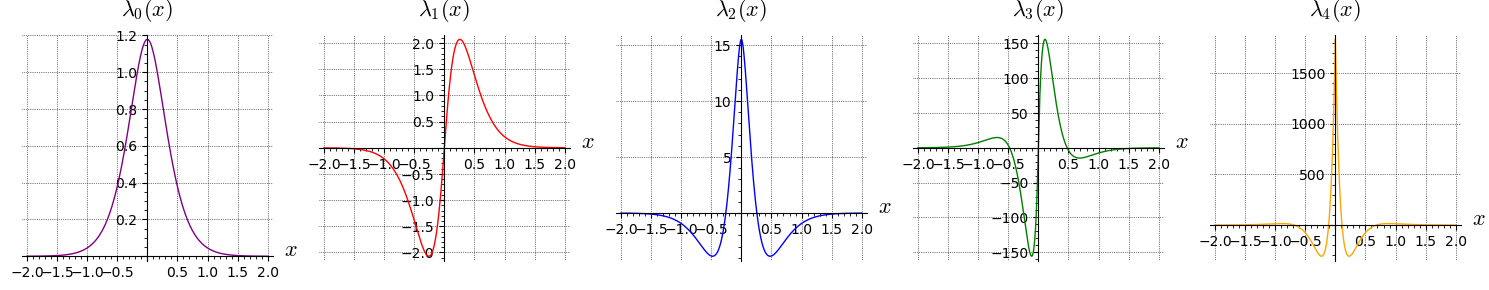

In [5]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(5):
    axes_label = [r'$x$', f'$\\lambda_{{{k}}}(x)$']
    p = plot(lambda_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

In [6]:
def rigorous_max_partial_derivatives(fx,fy, x1, x2, y1, y2):
    I_x = RBF(x1, x2)
    I_y = RBF(y1, y2)

    fx_eval = RBF(fx(x=I_x, y=I_y))
    fy_eval = RBF(fy(x=I_x, y=I_y))

    fx_sup = RBF(max(abs(fx_eval.lower()), abs(fx_eval.upper())))
    fy_sup = RBF(max(abs(fy_eval.lower()), abs(fy_eval.upper())))

    return fx_sup, fy_sup

#max_fx, max_fy = rigorous_max_partial_derivatives(f_expr, x1, x2, y1, y2)
# largeur = R(x2) - R(x1)
# hauteur = R(y2) - R(y1)
# error_bound = (largeur * hauteur / n) * (largeur * max_fx + hauteur * max_fy)
# print(f"Borne d'erreur théorique (approx.) : {error_bound}")

In [54]:
def grid(A,n,B=NaN,offset=0):
    if B==NaN:
        B=A ; A=-B
    if n==1:
        return [A]
    return ([A + (B-A)*(i+offset)/(n-1) for i in range(n)])

def grid_concentrated(A, B, y, n):

    t = [-1+ 2*i/(n-1) for i in range(n)]

    # On applique une fonction en cloche (gaussienne aplatie) pour concentrer autour de 0
    t_concentres = [xi * abs(xi)**0.5 for xi in t]

    # Transformation vers l'intervalle [A, B] concentrée autour de y
    largeur_gauche = y - A
    largeur_droite = B - y

    points = []
    for xi in t_concentres:
        if xi < 0:
            val = y + xi * largeur_gauche
        else:
            val = y + xi * largeur_droite
        points.append(val)

    return points

def riemann_sum(f, y1, y2, n):
    y_points = grid(y1,n,y2)
    def g(x):
        return sum(RBF(delta) * RBF(f(x, y_i)) for y_i in y_points)
    return y_points,g

def riemann_integral(f, x1, x2, y1, y2, n):

    dx = (RBF(x2) - RBF(x1))/n
    dy = (RBF(y2) - RBF(y1))/n

    total = RBF(0)
    for i in range(n):
        for j in range(n):
            xi = RBF(x1) + i*dx
            yj = RBF(y1) + j*dy
            total += f(xi, yj) * dx * dy
            if f(xi,yj).is_NaN():
                print(yj.center())
                print()
            sys.stdout.write(f"\rProgression : {int(((n*i+j) / (n**2)) * 100)}%") # Progress bar
            sys.stdout.flush()
    sys.stdout.write("\r" + " " * 30 + "\r")
    sys.stdout.flush()
    return total 

def delta_squared(K1,K2):
    def f(x,y):
        return (K1(x,y)-K2(x,y))**2
    return f

In [ ]:
def K(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2)) + exp(-(q+center)**2/(2 * sig**2))

def G(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2))

def fit_num(func, basis_pts, train_pts, sigma=1/2, basis_type='G'):
    true_vals = vector(RR, [func(x) for x in train_pts])    
    basis_num=len(basis_pts)
    train_num=len(train_pts)
    var('p, q, r')
    if basis_type == 'G':
        fG = fast_callable(G(p, q, r), vars=[p, q, r], domain=RR)
        M_norm = matrix(RR, train_num, basis_num, lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    elif basis_type == 'K':
        fG = fast_callable(K(p, q, r), vars=[p, q, r], domain=RR)
        M_norm = matrix(RR, train_num, basis_num, lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    
    # use numpy least squares to fit
    result, residual, rk, sth = np.linalg.lstsq(M_norm, true_vals, rcond=None)
    mse = np.mean((np.dot(M_norm, result) - true_vals)**2)
    
    # calculate the approximate function
    if basis_type == 'G':
        approx_fun = sum([result[j] * G(x, basis_pts[j], sigma) for j in range(basis_num)])
    elif basis_type == 'K':
        approx_fun = sum([result[j] * K(x, basis_pts[j], sigma) for j in range(basis_num)])        
    
    return result, approx_fun, mse

Mean squared error: 85007868.91981725
Mean squared error: 4805981.9095059885


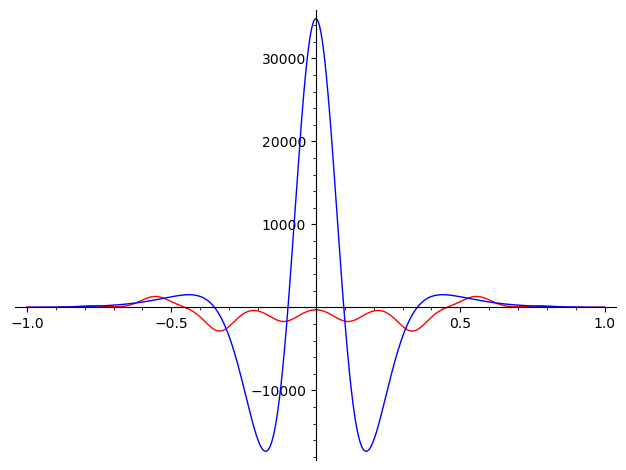

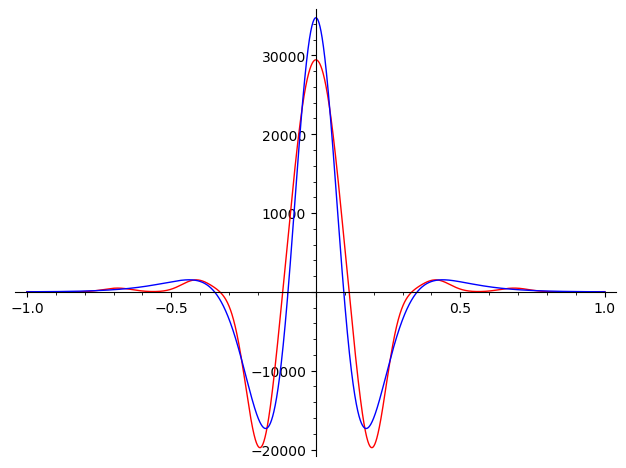

In [11]:
f=phi_funcs[0]

res, app, err = fit_num(f, basis_pts=grid(1,10),train_pts=grid(1,1000), basis_type='G', sigma=1/20, )
line1 = plot(app, (x, -1, 1),color='red')
line2 = plot(f, (x, -1, 1),color='blue')

res, app, err = fit_num(f, basis_pts=grid_concentrated(-1,1,0,10),train_pts=grid(1,1000), basis_type='G', sigma=1/20, )
line3 = plot(app, (x, -1, 1),color='red')
line4 = plot(f, (x, -1, 1),color='blue')

show(line1+line2)
show(line3+line4)

In [47]:
def compute_approx_kernel(K,x1,x2,y1,y2,n_riem,n_basis,n_train,sigma=1/2, basis_type='G'):
    riemann_points=grid(y1,n_riem,y2)
    basis_pts=grid(x1,n_basis,x2)
    train_pts=grid(x1,n_train,x2)
    c = [[0 for j in range(n_basis)] for i in range(n_riem)] # c[i] is the list of the coefficients of the gaussian kernel that approximates K(x,y_i)
    errors=[]
    for i in range(n_riem):
        coefficients, _, mse = fit_num(lambda x: K(x,riemann_points[i]), basis_pts, train_pts, sigma, basis_type)
        c[i]=coefficients 
        errors.append(mse)
    def eta(x_i,x):
        return lambda_funcs[0](x+x_i)
    def K_approx(x,y):
        s=RBF(0)
        for i in range(n_riem):
            for j in range(n_basis):
                s+= RBF(c[i][j])*RBF(G(x, basis_pts[j], sigma))*eta(riemann_points[i],y) 
        return s*((y2-y1)/n_riem) #THE DELTA WAS MISSING HERE !!
    print(f"MSE max = {max(errors)} ; MSE average: {mean(errors)}")
    return K_approx

def compute_approx_kernel_concentrated(K,A,n_riem,n_basis,n_train,sigma=1/2, basis_type='G'):
    riemann_points=grid(A,n_riem)
    train_pts=grid(A,n_train)
    c = [[0 for j in range(n_basis)] for i in range(n_riem)]
    for i in range(n_riem):
        coefficients, approx, err = fit_num(lambda x: K(x,riemann_points[i]), grid_concentrated(-A,A,riemann_points[i],n_basis), train_pts, sigma, basis_type)
        c[i]=coefficients 
    def eta(x_i,x):
        return lambda_funcs[0](x-x_i)
    def K_approx(x,y):
        s=RBF(0)
        for i in range(n_riem):
            for j in range(n_basis):
                s+= RBF(c[i][j])*RBF(G(x,RBF(grid_concentrated(-A,A,riemann_points[i],n_basis)[j]), sigma))*eta(riemann_points[i],y) 
        return s*(2*A/n_riem) 
    return K_approx


Some examples of kernel approximation
---

In [69]:
# First example with a nice function. We can observe that despite the fact that the gaussian kernel converges quite fast to a relevant approximation, the rate of convergence is pretty slow :
# L^2 error for a 20x20 grid : [0.24213298354645611527009855379086081525972906766468991270626727048507704464817209359 +/- 4.99e-84]
# L^2 error for a 40x40 grid : [0.1974516062190444277100886883318386625328517213038835652180062289031507379219911395 +/- 3.23e-83]
# L^2 error for a 80x80 grid : [0.188610547052896253372045283291878139980266698584153672865610066685072596406232665349 +/- 7.58e-85]

A=4
K=fast_callable(sin(x)*cos(y),vars=[x,y],domain=RBF)
K_app = compute_approx_kernel(K,-A,A,-A,A,10,10,500,1)

print(f"L^2 norm of the difference = {riemann_integral(delta_squared(K,K_app),-A,A,-A,A,50)}")

plot1=plot3d(sin(x)*cos(y),(x,-A,A),(y,-A,A),color='blue')
plot2=plot3d(K_n,(x,-A,A),(y,-A,A),color='red')
plot3=plot3d(delta_squared(K,K_app),(x,-A,A),(y,-A,A),color='purple')
L=[plot1,plot2,plot1+plot2,plot3]
h = sum(L[i].translate((i*(2*A+1),0,0)) for i in range(len(L)))
h.show()

MSE max = 2.5789503116477695e-05 ; MSE average: 1.3755592592176015e-05
L^2 norm of the difference = [0.71851109601441354425339319321644072073304364598254278488190763587243044868312322597067 +/- 6.37e-87]


Graphics3d Object

In [71]:
K=fast_callable(x**3 +y**2,vars=[x,y],domain=RBF)
K_n = compute_approx_kernel(K,-2,2,-2,2,15,15,1000,1/5)
plot1=plot3d(x**3 +y**2,(x,-1,1),(y,-1,1),color='blue')
plot2=plot3d(K_n,(x,-1,1),(y,-1,1),color='red')

show(plot1+plot2)

MSE max = 0.01572007657485152 ; MSE average: 0.014555378497257977


Graphics3d Object

Mean squared error: 1.1028808732981532e-05
Mean squared error: 2.5789503116477695e-05
Mean squared error: 9.489682019015462e-06
Mean squared error: 1.4284331881736613e-06
Mean squared error: 2.104153590423173e-05
Mean squared error: 2.104153590423173e-05
Mean squared error: 1.4284331881736613e-06
Mean squared error: 9.489682019015462e-06
Mean squared error: 2.5789503116477695e-05
Mean squared error: 1.1028808732981532e-05


Graphics3d Object

Graphics3d Object

Graphics3d Object

Progression : 99%
[0.71851109601441354425339319321644072073304364598254278488190763587243044868312322597067 +/- 6.37e-87]


In [15]:
# L^2 norm of the kernel on [-1,1]x[-1,1] = [133184377.97029109084252063996471540429154453286521468500387428956233104601941883554 +/- 8.27e-75]

# L^2 norm of the difference on [-1,1]x[-1,1] = [131354647.55096026783485651175729485990453503817095921034377021849013400102470583966 +/- 4.87e-75]

K=M_0_func
K_n = compute_approx_kernel(K,-1,1,20,20,500,1/20)

def f(x,y):
    return (K_n(x,y)-K(x,y))**2

print(riemann_integral(f,-1,1,-1,1,30))

Mean squared error: 0.006571616426739848
Mean squared error: 0.12332457799370118
Mean squared error: 1.3818310386255321
Mean squared error: 11.340726617850882
Mean squared error: 70.59962242506604
Mean squared error: 256.3133492738574
Mean squared error: 55.30787226385968
Mean squared error: 7691.588297993367
Mean squared error: 35527.73691999927
Mean squared error: 57045.16516415212
Mean squared error: 57045.165164152146
Mean squared error: 35527.73691999927
Mean squared error: 7691.588297993381
Mean squared error: 55.30787226385974
Mean squared error: 256.31334927385745
Mean squared error: 70.59962242506606
Mean squared error: 11.340726617850882
Mean squared error: 1.3818310386255324
Mean squared error: 0.12332457799370107
Mean squared error: 0.006571616426739838
Progression : 99%
[131387477.99226334744142961004660325967070197076369719575419088342548528792430743630 +/- 6.19e-75]


In [16]:
# Not so good convergence away from zero :

# L^2 norm of the kernel on [10,11]x[10,11] = [0.00025047973188319667278322759152714994674898442057658930294334997390951453285854094821497 +/- 4.35e-90]

# L^2 norm of the difference on [10,11]x[10,11] = [0.00025047973188319667278322759152714994674898442057658929073285356650073769102951131594965 +/- 3.97e-90]


x1=10
x2=11
y1=10
y2=11

K=M_0_func
K_n = compute_approx_kernel(K,x1,x2,20,20,400,10)

plot1=plot3d(K,(x,x1,x2),(y,y1,y2),color='blue')
show(plot1)

# def f(x,y):
#     return (K_n(x,y))**2

# print(riemann_integral(f,10,11,10,11,30))

Mean squared error: 7.317735246737874e-08
Mean squared error: 1.248522975375771e-07
Mean squared error: 1.6826254095638151e-07
Mean squared error: 1.6969953191313938e-07
Mean squared error: 1.257883918595792e-07
Mean squared error: 9.666425007403694e-08
Mean squared error: 1.7944838391189332e-07
Mean squared error: 4.279001786336762e-07
Mean squared error: 7.835511460096539e-07
Mean squared error: 1.0854030422751684e-06
Mean squared error: 1.1663589375963465e-06
Mean squared error: 9.725260247737097e-07
Mean squared error: 6.139064186038013e-07
Mean squared error: 2.979802639185917e-07
Mean squared error: 1.861250786915817e-07
Mean squared error: 2.8153368515582376e-07
Mean squared error: 4.4285362156531374e-07
Mean squared error: 5.139309247780776e-07
Mean squared error: 4.4838150891470576e-07
Mean squared error: 3.107109583591536e-07


Graphics3d Object

In [17]:
# Not so good convergence away from zero :

# L^2 norm of the kernel on [10,11]x[10,11] = [0.00025047973188319667278322759152714994674898442057658930294334997390951453285854094821497 +/- 4.35e-90]

# L^2 norm of the difference on [10,11]x[10,11] = [0.00025047973188319667278322759152714994674898442057658929073285356650073769102951131594965 +/- 3.97e-90]


x1=1.5
x2=4
y1=-1
y2=1

K=M_0_func
# K_n = compute_approx_kernel(K,x1,x2,20,20,400,10)

plot1=plot3d(K,(x,x1,x2),(y,y1,y2),color='blue')
show(plot1)

# def f(x,y):
#     return (K_n(x,y))**2

# print(riemann_integral(f,10,11,10,11,30))

Graphics3d Object